Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/mlfavorfit/lib/favorfit/kjg/diffusers_research/diffusers_research/diffusers/models/lora.py:387: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

/home/mlfavorfit/lib/favorfit/kjg/diffusers_research/diffusers_research/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

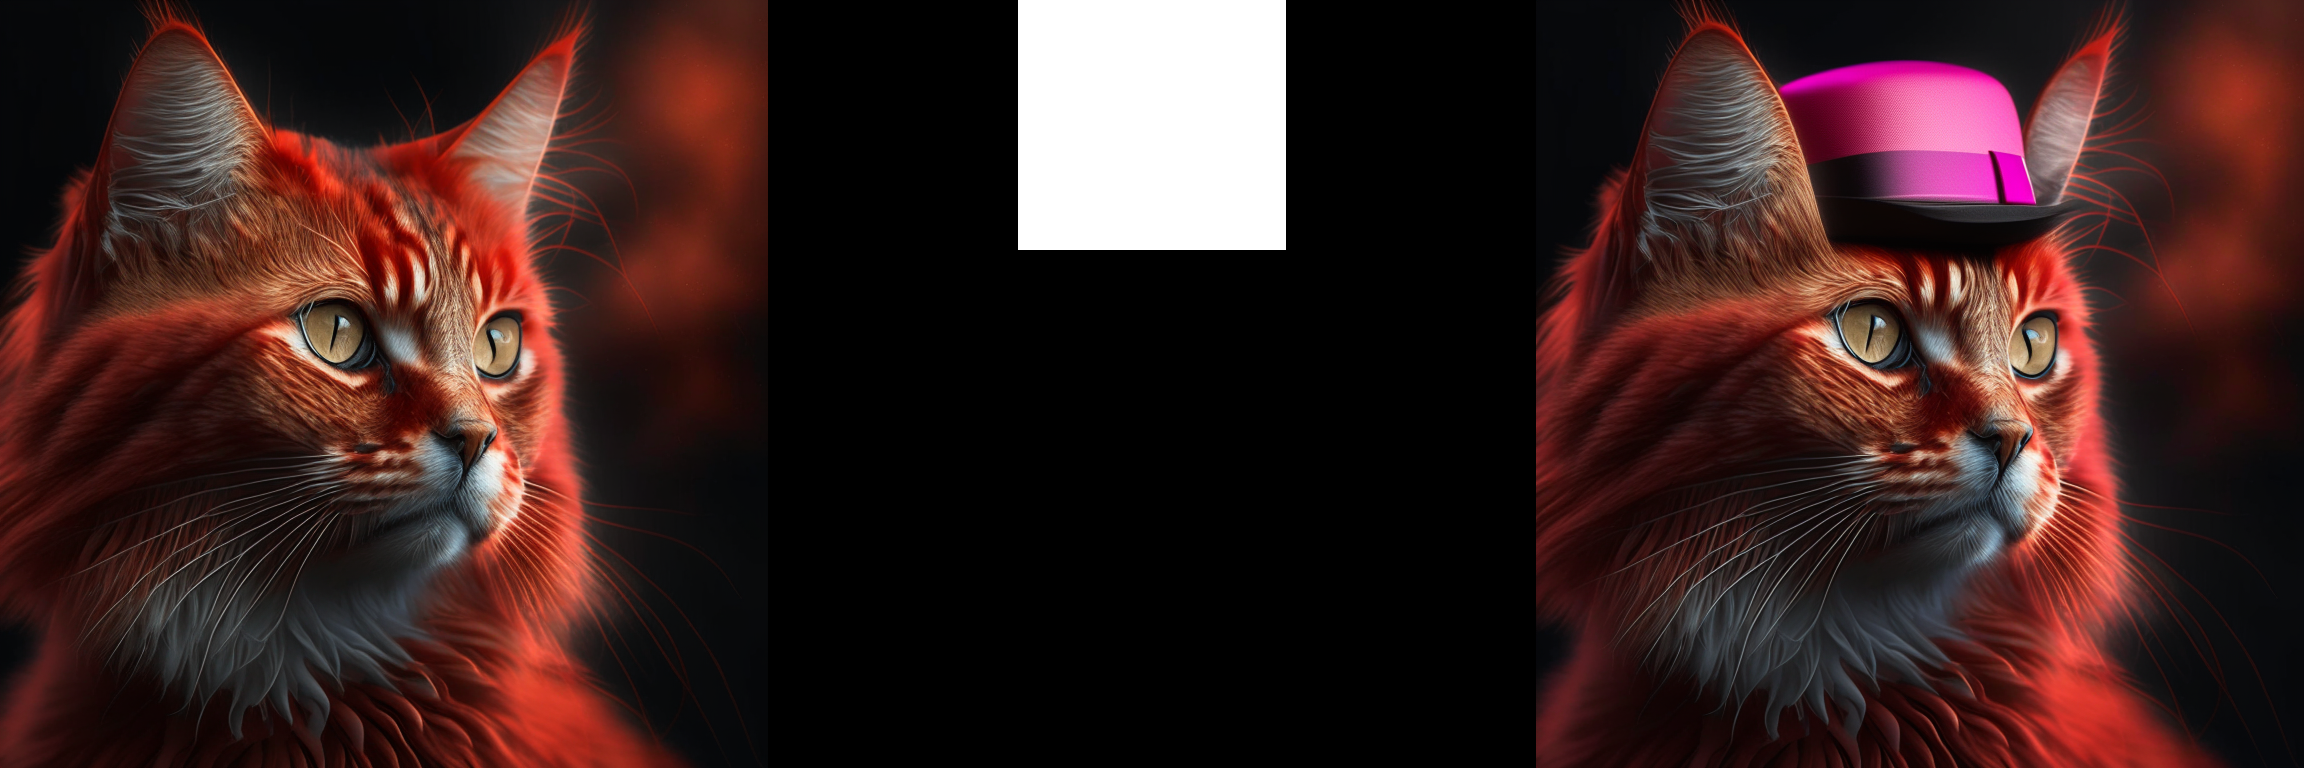

In [1]:
from diffusers import KandinskyV22InpaintPipeline, KandinskyV22PriorPipeline
from diffusers.utils import load_image, make_image_grid
import torch
import numpy as np
from PIL import Image

prior_pipeline = KandinskyV22PriorPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16, use_safetensors=True).to("cuda")
pipeline = KandinskyV22InpaintPipeline.from_pretrained("kandinsky-community/kandinsky-2-2-decoder-inpaint", torch_dtype=torch.float16, use_safetensors=True).to("cuda")

init_image = load_image("https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/kandinsky/cat.png")
mask = np.zeros((768, 768), dtype=np.float32)
# mask area above cat's head
mask[:250, 250:-250] = 1

prompt = "a hat"
negative_prompt = "white"
generator = torch.Generator()
generator.manual_seed(52)

prior_output = prior_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    generator=generator
    )
output_image = pipeline(image=init_image, 
                        mask_image=mask, 
                        **prior_output, 
                        height=768, 
                        width=768, 
                        num_inference_steps=50,
                        # strength=0.1,
                        generator=generator).images[0]

mask = Image.fromarray((mask*255).astype('uint8'), 'L')
make_image_grid([init_image, mask, output_image], rows=1, cols=3)

In [ ]:
from diffusers import KandinskyV22ControlnetImg2ImgPipeline

In [2]:
from PIL import Image

tp = Image.open("/home/mlfavorfit/Downloads/sample/composition/5_tp.jpg")
pr = Image.open("/home/mlfavorfit/Downloads/sample/composition/4_pr.jpg")

In [3]:
from PIL.ImageOps import invert
from utils import *

In [4]:
tp = center_crop_and_resize(tp)

In [5]:
import cv2

In [6]:
from Favorfit_remove_bg import inference as remove_bg
from Favorfit_image_to_text import clip_image_to_text

rmbg_model = remove_bg.call_model("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/remove_bg/remove_bg.pth", device="cuda")
clip_model = clip_image_to_text.load_interrogator("/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/image_to_text/clip", device="cuda")

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

/home/mlfavorfit/anaconda3/envs/diffusion_rnd/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [7]:
init_image = center_crop_and_resize(Image.open("/home/mlfavorfit/Downloads/sample/composition/5_pr.jpg").convert("RGB"))
mask = remove_bg.inference(init_image, rmbg_model).convert("L")
inverted_mask = invert(mask)

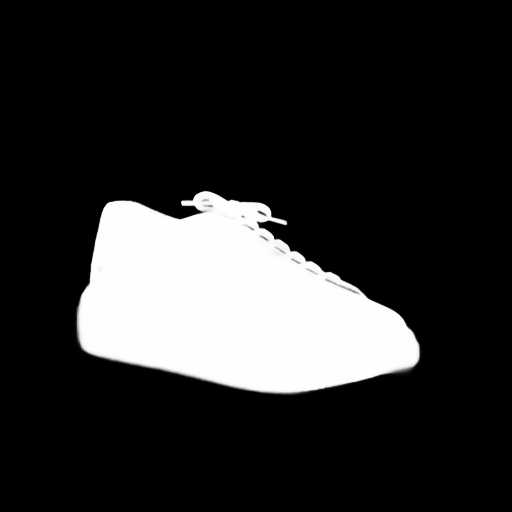

In [8]:
mask

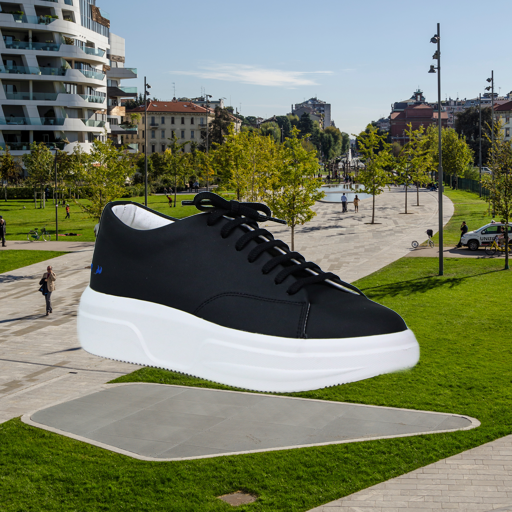

In [9]:
pr_and_tp_image = composing_image(tp, init_image, mask.convert("RGB"))
pr_and_tp_image

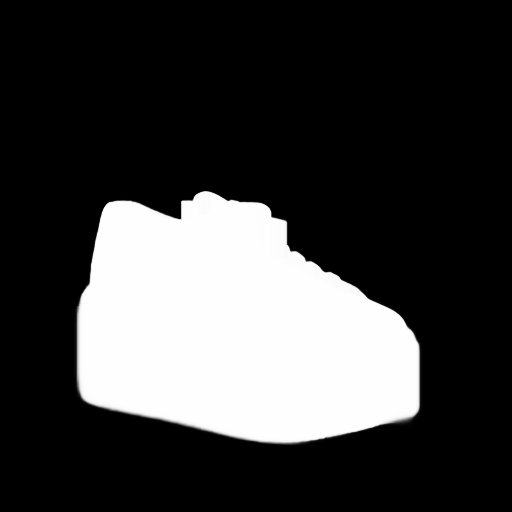

In [10]:
expand_mask = Image.fromarray(cv2.dilate(np.array(mask.convert("L")), (3,3), iterations=50))
expand_mask

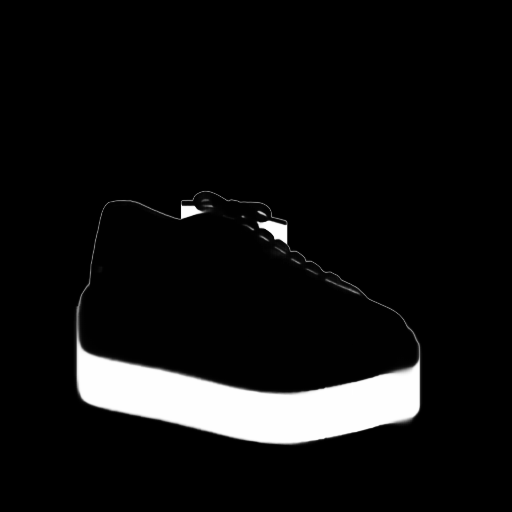

In [11]:
mask_np = np.array(invert(mask))
exp_mask_np = np.array(expand_mask)

combine_mask = mask_np * (exp_mask_np/255) + exp_mask_np * (1-exp_mask_np/255)
combine_mask = Image.fromarray(combine_mask).convert("RGB")
combine_mask

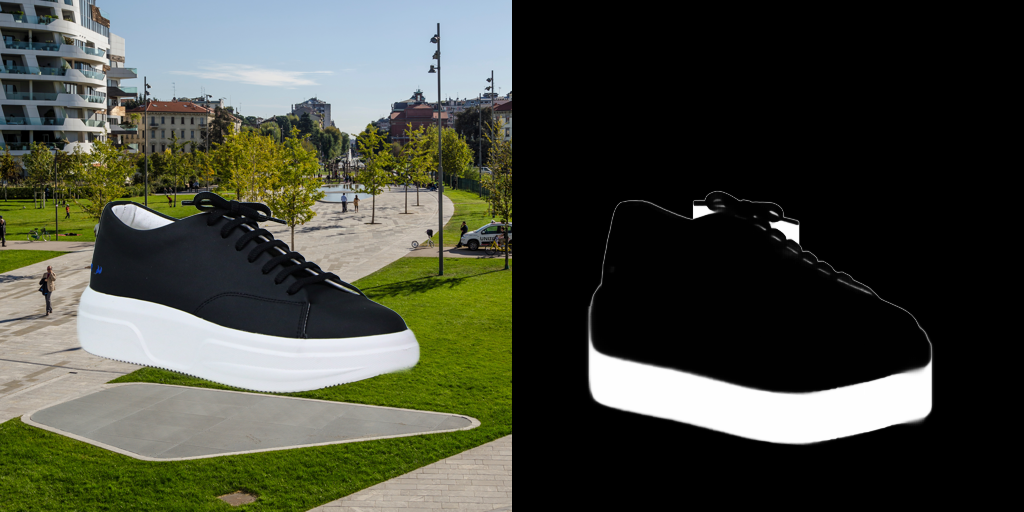

In [12]:
make_image_grid([pr_and_tp_image, combine_mask], rows=1, cols=2)

In [13]:
import random

In [35]:
caption = clip_image_to_text.inference(init_image, clip_model, mode="simple")
caption

'black shoe white soles white sole'

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

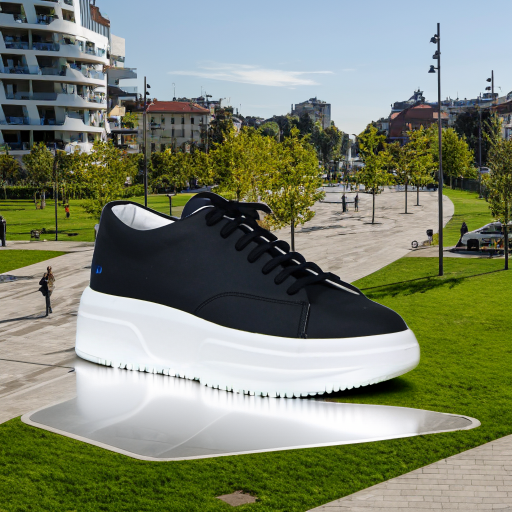

In [42]:
prompt = f"product photo, {caption}"
negative_prompt = "low quality, worst quality, wrinkled, deformed, distorted, jpeg artifacts,nsfw, paintings, sketches, text, watermark, username, spikey"

generator = torch.Generator()
generator.manual_seed(random.randint(0, 10000))
# generator.manual_seed(42)

prior_output = prior_pipeline(
    prompt=prompt,
    negative_prompt=negative_prompt,
    guidance_scale=4.0,
    generator=generator
    )
output_image = pipeline(image=pr_and_tp_image, 
                        mask_image=combine_mask, 
                        **prior_output, 
                        height=512,
                        width=512, 
                        num_inference_steps=20,
                        strength=0.8,
                        guidance_scale=4.0,
                        generator=generator).images[0]

output_image

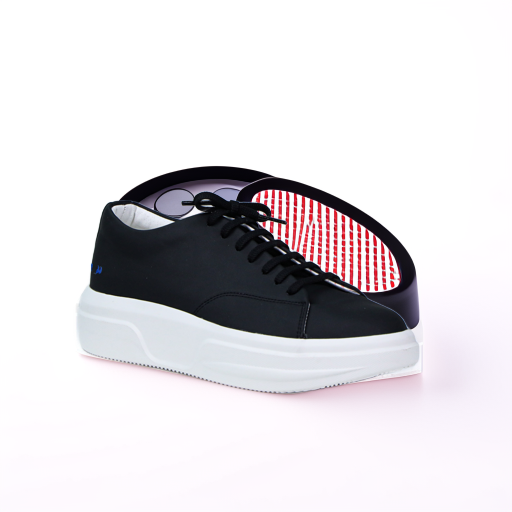

In [151]:
composing_image(init_image,output_image, inverted_mask.convert("RGB"))

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extr

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/mlfavorfit/lib/favorfit/kjg/diffusers_research/diffusers_research/diffusers/models/lora.py:387: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

/home/mlfavorfit/lib/favorfit/kjg/diffusers_research/diffusers_research/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)
Token indices sequence length is longer than the specified maximum sequence length for this model (112 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endofte

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

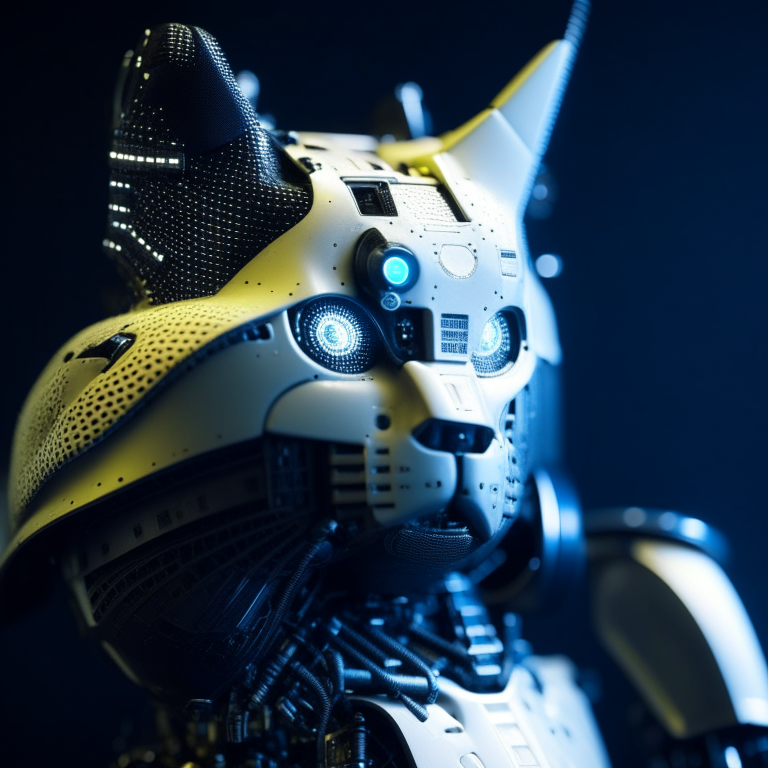

In [1]:
import torch
import numpy as np

from transformers import pipeline
from diffusers.utils import load_image

from diffusers import KandinskyV22PriorPipeline, KandinskyV22ControlnetPipeline

# let's take an image and extract its depth map.
def make_hint(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint

img = load_image(
    "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/kandinskyv22/cat.png"
).resize((768, 768))

# We can use the `depth-estimation` pipeline from transformers to process the image and retrieve its depth map.
depth_estimator = pipeline("depth-estimation")
hint = make_hint(img, depth_estimator).unsqueeze(0).half().to("cuda")

# Now, we load the prior pipeline and the text-to-image controlnet pipeline
pipe_prior = KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
)
pipe_prior = pipe_prior.to("cuda")

pipe = KandinskyV22ControlnetPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-controlnet-depth", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

# We pass the prompt and negative prompt through the prior to generate image embeddings
prompt = "A robot, 4k photo"
negative_prior_prompt = "lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"

generator = torch.Generator(device="cuda").manual_seed(43)
image_emb, zero_image_emb = pipe_prior(
    prompt=prompt, negative_prompt=negative_prior_prompt, generator=generator
).to_tuple()

# Now we can pass the image embeddings and the depth image we extracted to the controlnet pipeline. With Kandinsky 2.2, only prior pipelines accept `prompt` input. You do not need to pass the prompt to the controlnet pipeline.
images = pipe(
    image_embeds=image_emb,
    negative_image_embeds=zero_image_emb,
    hint=hint,
    num_inference_steps=50,
    generator=generator,
    height=768,
    width=768,
).images
images[0]


No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extr

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

The config attributes {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} were passed to KandinskyV22ControlnetInpaintPipeline, but are not expected and will be ignored. Please verify your model_index.json configuration file.
Keyword arguments {'prior': ['diffusers', 'PriorTransformer'], 'image_encoder': ['transformers', 'CLIPVisionModelWithProjection'], 'image_processor': ['transformers', 'CLIPImageProcessor']} are not expected by KandinskyV22ControlnetInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (112 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>', 'gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature']


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

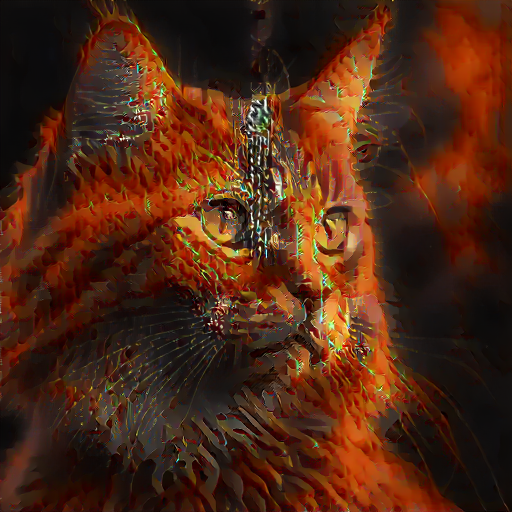

In [1]:
import torch
import numpy as np

from transformers import pipeline
from diffusers.utils import load_image

from diffusers import KandinskyV22PriorPipeline
from diffusers.pipelines.kandinsky2_2.pipline_kandinsky2_2_controlnet_inpainting import KandinskyV22ControlnetInpaintPipeline

# let's take an image and extract its depth map.
def make_hint(image, depth_estimator):
    image = depth_estimator(image)["depth"]
    image = np.array(image)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    detected_map = torch.from_numpy(image).float() / 255.0
    hint = detected_map.permute(2, 0, 1)
    return hint

img = load_image(
    "https://huggingface.co/datasets/hf-internal-testing/diffusers-images/resolve/main/kandinskyv22/cat.png"
).resize((512, 512))

mask = np.zeros((512, 512), dtype=np.float32)
# mask area above cat's head
mask[:250, 250:-250] = 1

# We can use the `depth-estimation` pipeline from transformers to process the image and retrieve its depth map.
depth_estimator = pipeline("depth-estimation")
hint = make_hint(img, depth_estimator).unsqueeze(0).half().to("cuda")

# Now, we load the prior pipeline and the text-to-image controlnet pipeline
prior_pipeline = KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
)
prior_pipeline = prior_pipeline.to("cuda")

pipe = KandinskyV22ControlnetInpaintPipeline.from_pretrained(
    "/home/mlfavorfit/Desktop/lib_link/favorfit/kjg/0_model_weights/diffusion/Kandinsky/kandinsky-inpainting-controlnet", torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

# We pass the prompt and negative prompt through the prior to generate image embeddings
prompt = "A robot, 4k photo"
negative_prior_prompt = "lowres, text, error, cropped, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck, username, watermark, signature"

generator = torch.Generator(device="cuda").manual_seed(43)
prior_output = prior_pipeline(
    prompt=prompt, negative_prompt=negative_prior_prompt, generator=generator
)

output_image = pipe(image=img, 
                    mask_image=mask,
                    hint=hint, 
                    **prior_output, 
                    height=512,
                    width=512, 
                    num_inference_steps=20,
                    strength=1.0,
                    guidance_scale=4.0,
                    generator=generator).images[0]

output_image